In [1]:
import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.load import load_feature_matrices, load_metadata
from scripts.features import save_ctms, save_sequences
from utils.frobenius import create_frobenius_adjacency_matrix
from utils.metrics import create_cosine_adjacency, create_kl_adjacency
from models.graph import create_movie_nodes, MovieGraph

In [2]:
save_sequences("../data/midis", "../data/sequences")
save_ctms("../data/midis", "../data/ctms")

Processing MIDIs: 0it [00:00, ?it/s]

Processing MIDIs: 17it [00:04,  4.38it/s]/home/jyanespu/project-02807/.venv/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing MIDIs: 88it [00:16,  5.25it/s]
2025-11-12 16:59:37.389 | SUCCESS  | scripts.features:save_sequences:127 - Processed 88 MIDI files -> saved to ../data/sequences/sequences_summary.csv
Processing MIDIs: 88it [00:14,  6.17it/s]
2025-11-12 16:59:51.679 | SUCCESS  | scripts.features:save_ctms:91 - Processed 88 MIDI files -> saved to ../data/ctms/summary.csv


In [3]:
matrices_df = load_feature_matrices("../data/ctms")
metadata_df = load_metadata("../data/metadata/movies_metadata.csv")

# Normalize each CTM so the total sum is 1
def normalize_rowwise(M: np.ndarray) -> np.ndarray:
    M = M.astype(np.float64)          # convert to float
    row_sums = M.sum(axis=1, keepdims=True)
    return np.divide(M, row_sums, out=np.zeros_like(M), where=row_sums!=0)

def normalize_global(M: np.ndarray) -> np.ndarray:
    M = M.astype(np.float64)               # convert to float
    total = M.sum()                         # sum of all elements
    return np.divide(M, total, out=np.zeros_like(M), where=total!=0)

matrices_df['matrix'] = matrices_df['matrix'].apply(normalize_global)

metadata_df = metadata_df.loc[matrices_df.index] # align matrices and metadata

Loading matrices: 92it [00:00, 1277.14it/s]
2025-11-12 16:59:51.805 | SUCCESS  | utils.load:load_feature_matrices:45 - Loaded 92 matrices from ../data/ctms


In [4]:
ctms_list = matrices_df['matrix'].tolist()
distance_matrix = create_kl_adjacency(ctms_list)

Computing KL adjacency (unmasked): 100%|██████████| 92/92 [00:00<00:00, 258.67it/s]


In [5]:
print(metadata_df.head())
nodes = create_movie_nodes(metadata_df)
graph = MovieGraph(nodes, distance_matrix)

                                     title     released  \
id                                                        
tt0026138            Bride of Frankenstein  06 May 1935   
tt0029583  Snow White and the Seven Dwarfs  04 Feb 1938   
tt0032138                 The Wizard of Oz  25 Aug 1939   
tt0040076           Adventures of Don Juan  29 Jan 1949   
tt0045152              Singin' in the Rain  10 Apr 1952   

                                                director  imdbrating  \
id                                                                     
tt0026138                                    James Whale         7.8   
tt0029583  William Cottrell, David Hand, Wilfred Jackson         7.6   
tt0032138    Victor Fleming, George Cukor, Norman Taurog         8.1   
tt0040076                                Vincent Sherman         7.0   
tt0045152                      Stanley Donen, Gene Kelly         8.3   

                                                     ratings  \
id               

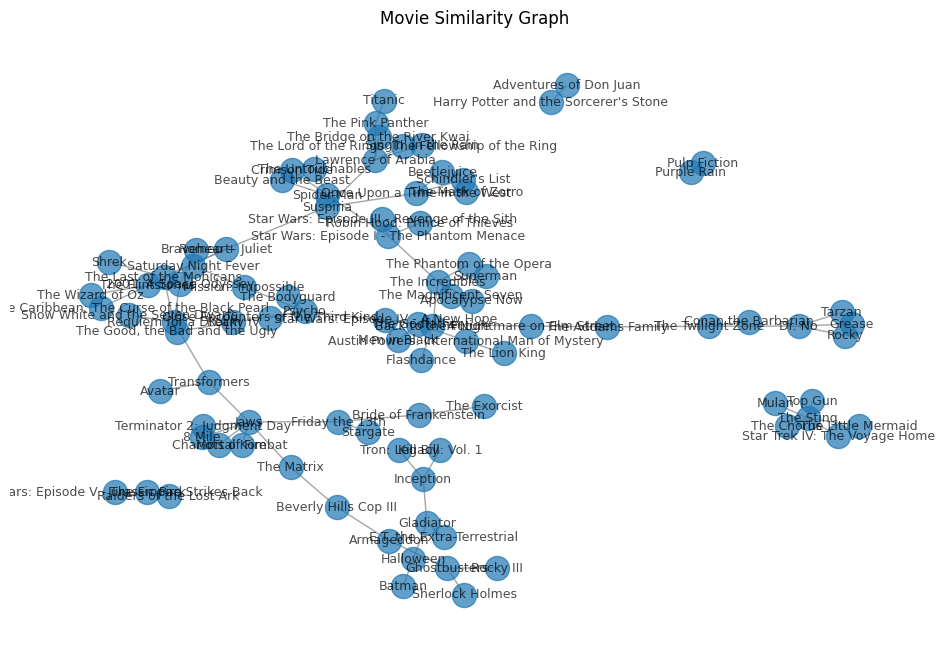

In [6]:
threshold = np.percentile(distance_matrix[np.triu_indices_from(distance_matrix, 1)], 75)
graph.plot_graph_networkx(distance_matrix, k=1, threshold=threshold, layout="spring")

**Recall:** For small $k$ (e.g. 2, 3), only the very closest neighbors are connected. Can create many disconnected components.

### Exploring the data

In [7]:
import numpy as np

def top_similar_movies_list(adjacency_matrix, nodes, top_k=10):
    """
    Returns a list of the top_k most similar movie pairs (shortest Frobenius distance).
    
    Args:
        adjacency_matrix (np.ndarray): Frobenius distance matrix.
        nodes (list): List of MovieNode objects.
        top_k (int): Number of top pairs to return.
    
    Returns:
        list of tuples: [(movie1_title, movie2_title, distance), ...]
    """
    n = adjacency_matrix.shape[0]
    triu_idx = np.triu_indices(n, k=1)  # upper triangle indices
    all_pairs = [(i, j, adjacency_matrix[i, j]) for i, j in zip(*triu_idx)]
    all_pairs.sort(key=lambda x: x[2], reverse=False)  # smallest distance = most similar
    top_pairs = all_pairs[:top_k]
    
    return [(nodes[i].title, nodes[j].title, dist) for i, j, dist in top_pairs]

# Usage example:
top_10 = top_similar_movies_list(distance_matrix, graph.nodes, top_k=10)
for m1, m2, dist in top_10:
    print(f"{m1} <-> {m2}: distance={dist:.2f}")


Adventures of Don Juan <-> Harry Potter and the Sorcerer's Stone: distance=2.17
Star Wars: Episode V - The Empire Strikes Back <-> Harry Potter and the Sorcerer's Stone: distance=3.10
Adventures of Don Juan <-> Apocalypse Now: distance=3.37
Superman <-> Star Wars: Episode V - The Empire Strikes Back: distance=3.88
Adventures of Don Juan <-> Star Wars: Episode V - The Empire Strikes Back: distance=4.04
Apocalypse Now <-> Harry Potter and the Sorcerer's Stone: distance=4.33
Star Wars: Episode V - The Empire Strikes Back <-> Raiders of the Lost Ark: distance=4.51
Superman <-> Raiders of the Lost Ark: distance=4.54
Star Wars: Episode V - The Empire Strikes Back <-> Star Wars: Episode III - Revenge of the Sith: distance=4.56
Superman <-> Harry Potter and the Sorcerer's Stone: distance=4.59


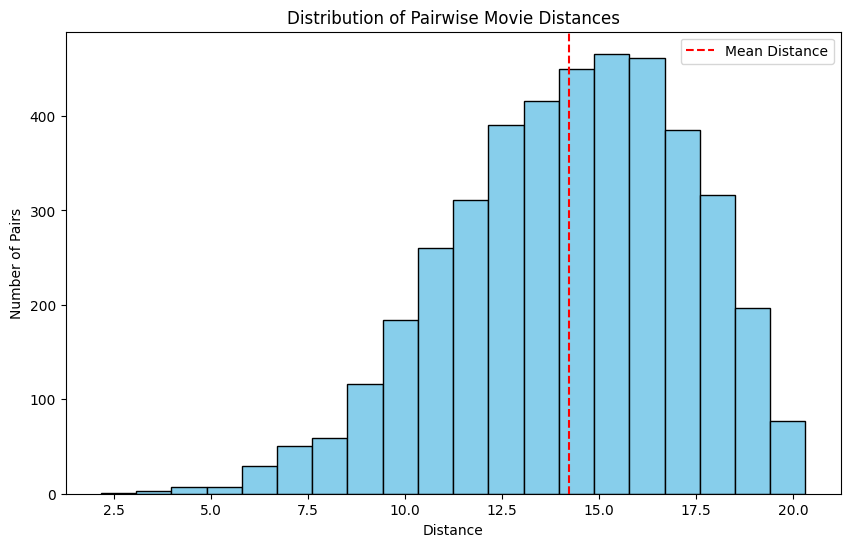

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Get upper triangle indices, excluding the diagonal
triu_idx = np.triu_indices(distance_matrix.shape[0], k=1)
all_distances = distance_matrix[triu_idx]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_distances, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Pairwise Movie Distances")
plt.xlabel("Distance")
plt.ylabel("Number of Pairs")
plt.axvline(np.mean(all_distances), color='red', linestyle='dashed', label='Mean Distance')
plt.legend()
plt.show()

Best matching movies based on CTM similarity:


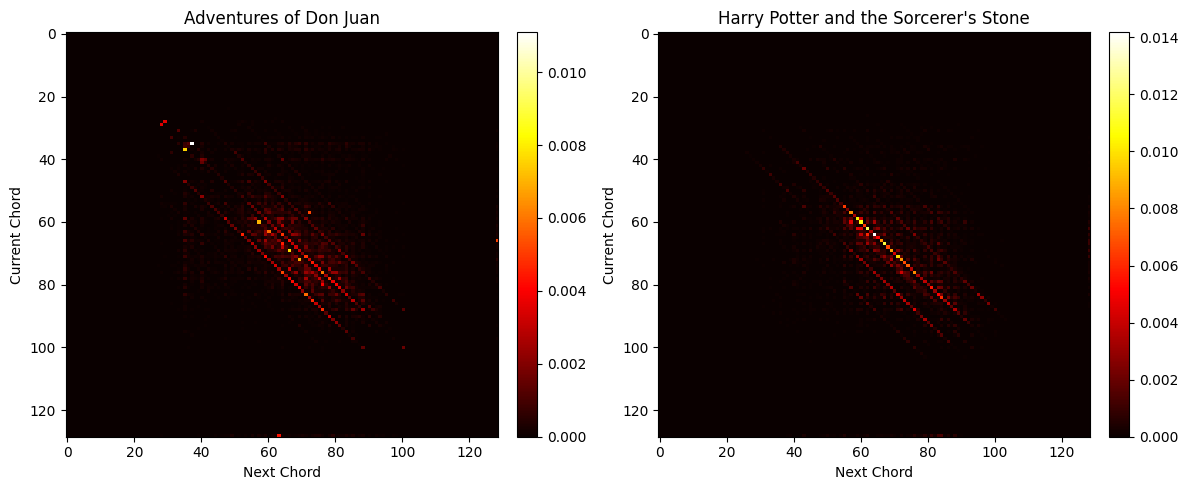


Worst matching movies based on CTM similarity:


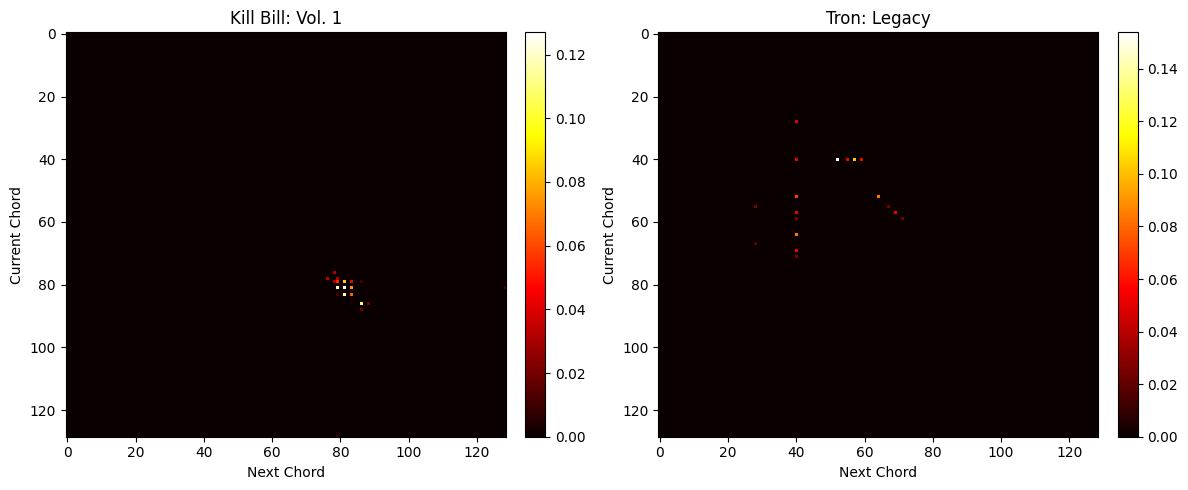

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ctms_side_by_side(matrices_df, metadata_df, titles):
    """
    Plot CTMs of two movies side by side for visual comparison.
    
    Args:
        matrices_df (pd.DataFrame): DataFrame with 'matrix' column.
        metadata_df (pd.DataFrame): DataFrame with 'title' column matching matrices_df.
        titles (list[str]): List of exactly two movie titles to plot.
    """
    if len(titles) != 2:
        raise ValueError("Please provide exactly two movie titles.")
    
    # Select matrices corresponding to titles
    mask = metadata_df['title'].isin(titles)
    matrices_to_plot = matrices_df[mask].reset_index(drop=True)
    titles_to_plot = metadata_df[mask]['title'].tolist()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for ax, row, title in zip(axes, matrices_to_plot.itertuples(), titles_to_plot):
        matrix = row.matrix
        im = ax.imshow(matrix, cmap='hot', aspect='auto', interpolation='nearest')
        ax.set_title(title)
        ax.set_xlabel("Next Chord")
        ax.set_ylabel("Current Chord")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Compare two chosen movies
print("Best matching movies based on CTM similarity:")
plot_ctms_side_by_side(matrices_df, metadata_df, titles=["Harry Potter and the Sorcerer's Stone", "Adventures of Don Juan"])

print("\nWorst matching movies based on CTM similarity:")
plot_ctms_side_by_side(matrices_df, metadata_df, titles=["Kill Bill: Vol. 1", "Tron: Legacy"])

## Spectral clustering

### Step 1: Distances to similarity

In [10]:
def distance_to_similarity(D: np.ndarray, sigma: float = None) -> np.ndarray:
    """
    Convert distance matrix D to similarity matrix S using a Gaussian kernel.
    """
    # Heuristic for sigma: median of non-zero distances
    if sigma is None:
        sigma = np.median(dist_matrix[D > 0]) / 2  # or even /3
        print(f"Using sigma = {sigma:.4f}")
    
    S = np.exp(-D**2 / (2 * sigma**2))
    np.fill_diagonal(S, 0)  # no self-similarity links
    return S

dist_matrix = create_kl_adjacency(ctms_list)
sim_matrix = distance_to_similarity(dist_matrix)

Computing KL adjacency (unmasked): 100%|██████████| 92/92 [00:02<00:00, 38.70it/s]

Using sigma = 7.2416


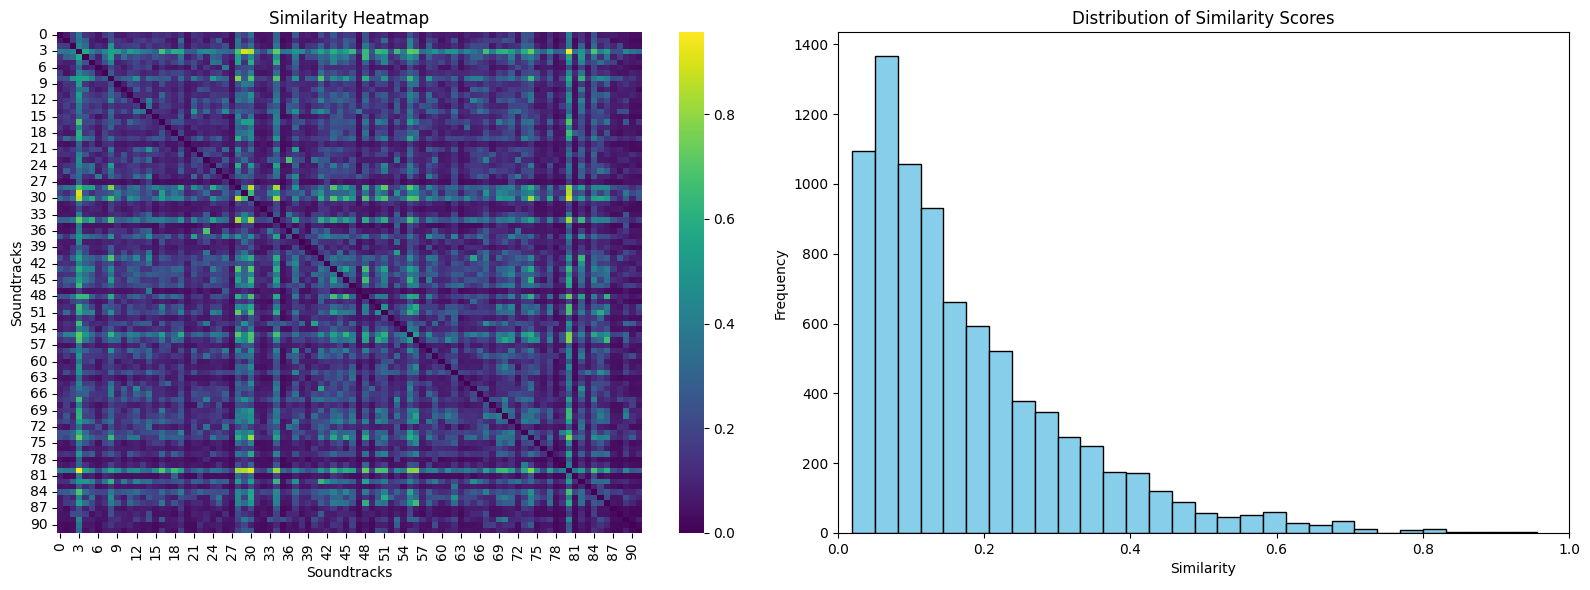

Mean similarity: 0.1788
Standard deviation: 0.1415


In [11]:
import seaborn as sns

sim_values = sim_matrix[~np.eye(sim_matrix.shape[0], dtype=bool)]

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(sim_matrix, cmap="viridis", ax=axes[0])
axes[0].set_title("Similarity Heatmap")
axes[0].set_xlabel("Soundtracks")
axes[0].set_ylabel("Soundtracks")

# Histogram
axes[1].hist(sim_values.flatten(), bins=30, color='skyblue', edgecolor='black')
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

mean_sim = np.mean(sim_values)
std_sim = np.std(sim_values)

print(f"Mean similarity: {mean_sim:.4f}")
print(f"Standard deviation: {std_sim:.4f}")

### Step 2: Compute the Laplacian

In [12]:
from scipy.linalg import fractional_matrix_power

D = np.diag(sim_matrix.sum(axis=1))
D_inv_sqrt = fractional_matrix_power(D, -0.5)
L_sym = np.eye(sim_matrix.shape[0]) - D_inv_sqrt @ sim_matrix @ D_inv_sqrt

### Step 3: Take the first $k$ eigenvectors

In [13]:
from scipy.linalg import eigh
from sklearn.preprocessing import normalize

k = 6  # desired number of clusters
eigvals, eigvecs = eigh(L_sym)

# Take the first k eigenvectors
X = eigvecs[:, :k]

X_norm = normalize(X, norm='l2', axis=1)

### Step 4: Run k-means on the eigenvectors

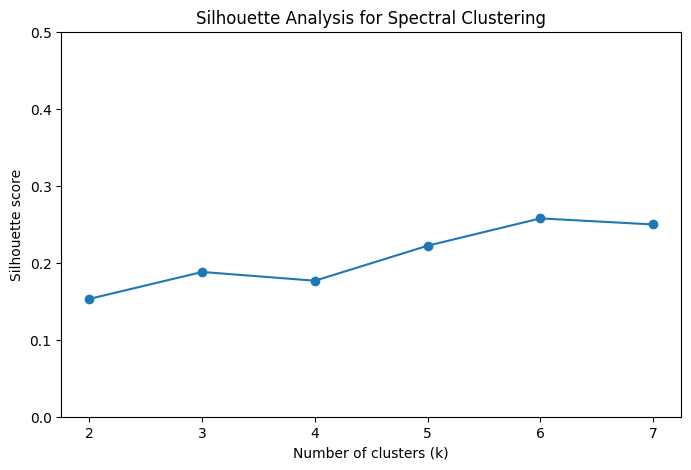

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, k+2)  # test from 2 to k+2 clusters
scores = []

for k_iter in k_values:
    kmeans = KMeans(n_clusters=k_iter, random_state=42)
    labels = kmeans.fit_predict(X_norm)
    score = silhouette_score(X_norm, labels)
    scores.append(score)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.ylim(0, 0.5)
plt.title("Silhouette Analysis for Spectral Clustering")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_norm)  # X_norm from Laplacian step
print("Fitting KMeans with k =", k)

metadata_df['cluster'] = labels
matrices_df['cluster'] = labels

score = silhouette_score(X_norm, labels)
print(f"Silhouette score for k = {k}: {score:.4f}")

Fitting KMeans with k = 6
Silhouette score for k = 6: 0.2576


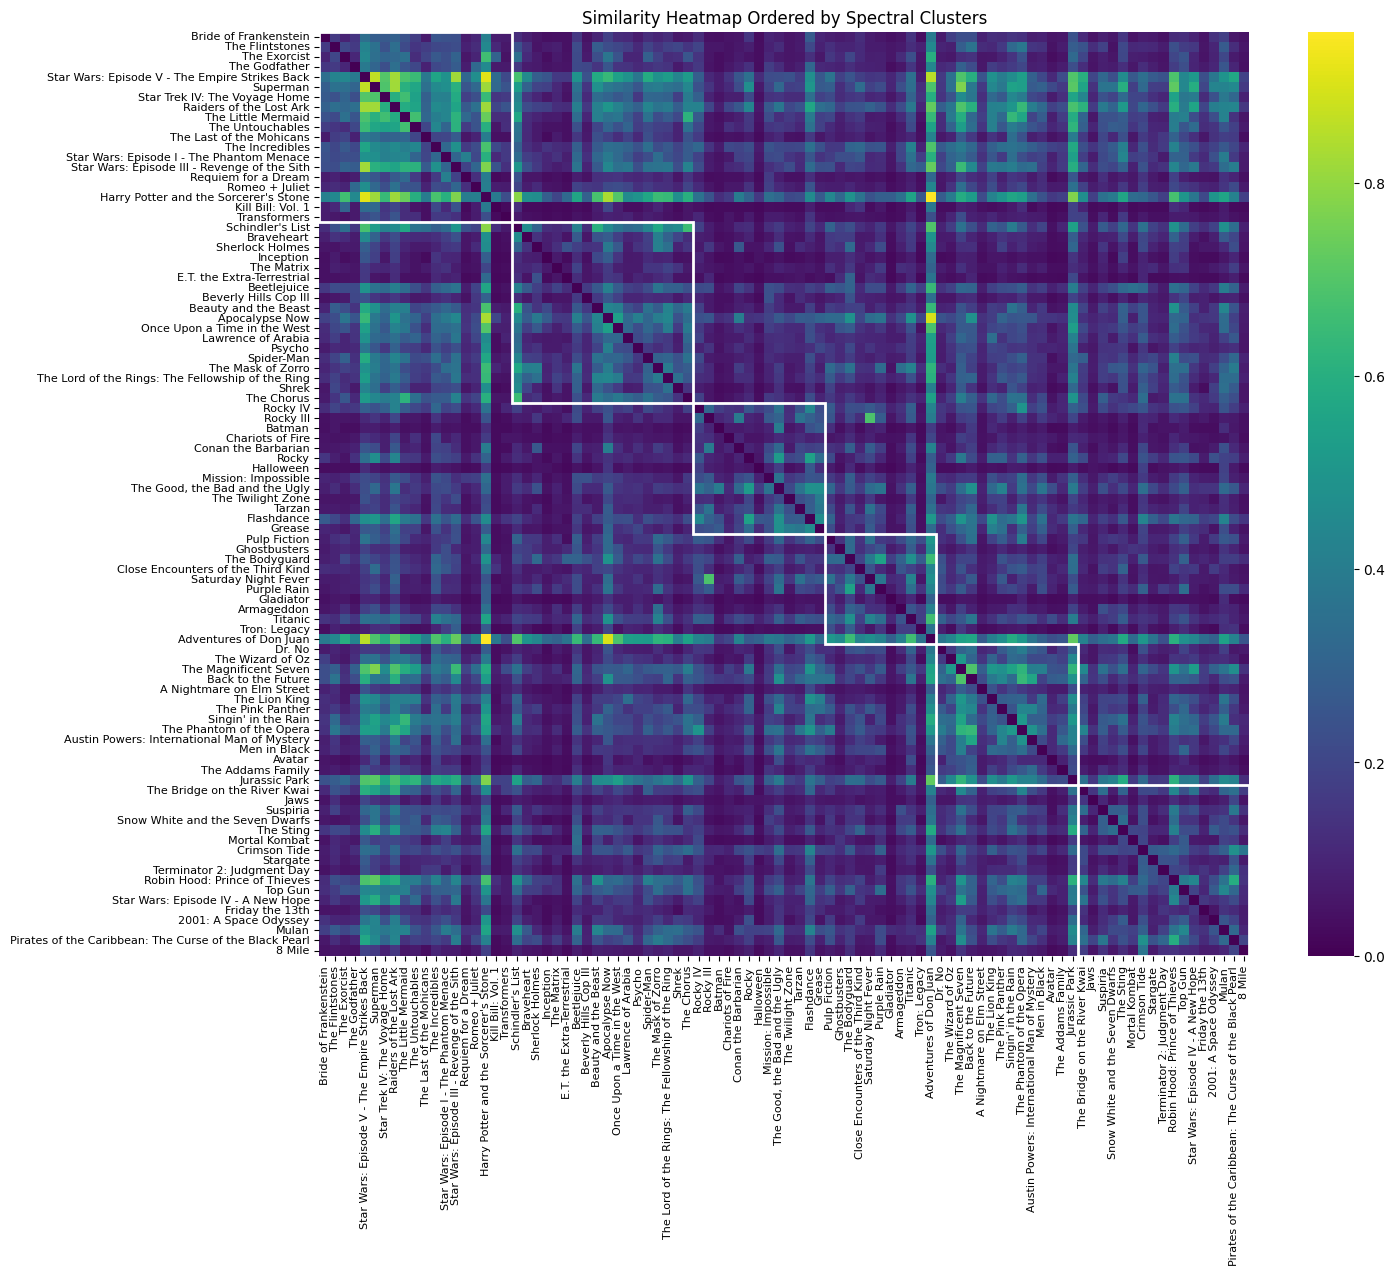

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Order indices by cluster
order = np.argsort(labels)
sim_ordered = sim_matrix[np.ix_(order, order)]
titles_ordered = metadata_df['title'].iloc[order].to_list()
labels_ordered = labels[order]

# Identify cluster boundaries
boundaries = [0]  # start index
current_label = labels_ordered[0]
for i, label in enumerate(labels_ordered):
    if label != current_label:
        boundaries.append(i)
        current_label = label
boundaries.append(len(labels_ordered))  # end index

# Plot heatmap
plt.figure(figsize=(15, 12))
ax = sns.heatmap(sim_ordered, xticklabels=titles_ordered, yticklabels=titles_ordered, cmap="viridis")
plt.title("Similarity Heatmap Ordered by Spectral Clusters")
plt.xticks(rotation=90, fontsize=8)  # smaller x-axis labels
plt.yticks(rotation=0, fontsize=8)   # smaller y-axis labels

# Add boxes along the diagonal for each cluster
for i in range(len(boundaries)-1):
    start = boundaries[i]
    end = boundaries[i+1]
    width = end - start
    rect = Rectangle((start, start), width, width, fill=False, edgecolor='white', linewidth=2)
    ax.add_patch(rect)

plt.show()

In [23]:
for cluster_id in range(k):
    print(f"\nCluster {cluster_id+1}:")
    print(metadata_df[metadata_df['cluster'] == cluster_id]['title'].values)


Cluster 1:
['Bride of Frankenstein' 'The Flintstones' 'The Godfather' 'The Exorcist'
 'Superman' 'Star Wars: Episode V - The Empire Strikes Back'
 'Raiders of the Lost Ark' 'Star Trek IV: The Voyage Home'
 'The Untouchables' 'The Little Mermaid' 'The Last of the Mohicans'
 'Romeo + Juliet' 'Star Wars: Episode I - The Phantom Menace'
 'Star Wars: Episode III - Revenge of the Sith' 'Requiem for a Dream'
 "Harry Potter and the Sorcerer's Stone" 'Kill Bill: Vol. 1'
 'The Incredibles' 'Transformers']

Cluster 2:
['Psycho' 'Lawrence of Arabia' 'Once Upon a Time in the West'
 'Apocalypse Now' 'E.T. the Extra-Terrestrial' 'Beetlejuice'
 'Beauty and the Beast' "Schindler's List" 'Beverly Hills Cop III'
 'Braveheart' 'The Lord of the Rings: The Fellowship of the Ring'
 'The Mask of Zorro' 'Shrek' 'The Matrix' 'Spider-Man' 'The Chorus'
 'Sherlock Holmes' 'Inception']

Cluster 3:
['The Twilight Zone' 'Mission: Impossible'
 'The Good, the Bad and the Ugly' 'Rocky' 'Grease' 'Halloween'
 'Chariots o

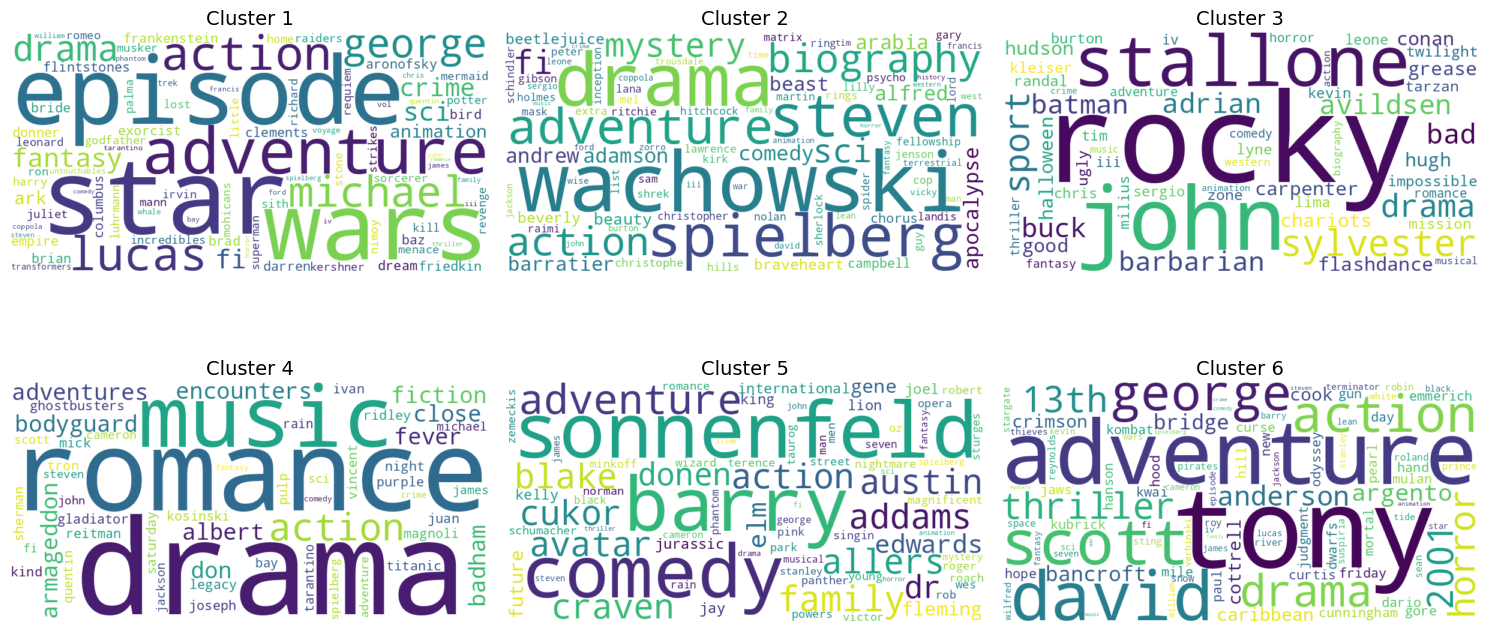

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

# Load full metadata CSV (with all columns)
full_metadata = pd.read_csv("../data/metadata/movies_metadata.csv", index_col=0)  # 'id' as index

# Drop exact duplicated columns if any
full_metadata = full_metadata.loc[:, ~full_metadata.columns.duplicated()]

# Merge cluster assignments with full metadata on 'id'
merged_df = metadata_df.merge(full_metadata, left_on='id', right_index=True, how='left', suffixes=('', '_meta'))

# Determine which columns exist for text extraction
possible_text_columns = ['title', 'Title', 'genres', 'genre', 'director', 'Director']
text_columns = [c for c in possible_text_columns if c in merged_df.columns]

# Combine text fields into a single string per movie
merged_df['combined_text'] = merged_df[text_columns].fillna('').agg(' '.join, axis=1)

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(merged_df['combined_text'])

# Function to generate TF-IDF word cloud for a cluster
def generate_cluster_wordcloud(cluster_id):
    cluster_texts = merged_df[merged_df['cluster'] == cluster_id]['combined_text']
    cluster_text = ' '.join(cluster_texts)

    tfidf_vector = vectorizer.transform([cluster_text])
    words = vectorizer.get_feature_names_out()
    scores = tfidf_vector.toarray().flatten()
    word_scores = {word: score for word, score in zip(words, scores) if score > 0}

    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(word_scores)
    return wc

# Get unique clusters
cluster_ids = sorted(merged_df['cluster'].unique())

# Choose grid layout automatically (e.g., 2x3 for 6 clusters)
n_clusters = len(cluster_ids)
n_cols = math.ceil(math.sqrt(n_clusters))
n_rows = math.ceil(n_clusters / n_cols)

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten in case of single row/col

# Generate and plot each word cloud
for idx, cluster_id in enumerate(cluster_ids):
    wc = generate_cluster_wordcloud(cluster_id)
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"Cluster {cluster_id+1}", fontsize=14)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()